In [1]:
!pip install pmdarima
import pmdarima as pm
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit
import pandas as pd
import numpy as np
import datetime
import requests
import warnings

import matplotlib.pyplot as plt
import matplotlib
import matplotlib.dates as mdates

from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OrdinalEncoder

from sklearn.model_selection import train_test_split
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings('ignore')

In [2]:
def mase(actual, forecast):
    n = len(actual)
    numerator = np.mean(np.abs(actual - forecast))
    denominator = np.mean(np.abs(np.diff(actual)))
    return numerator / denominator

Text(0, 0.5, 'Values')

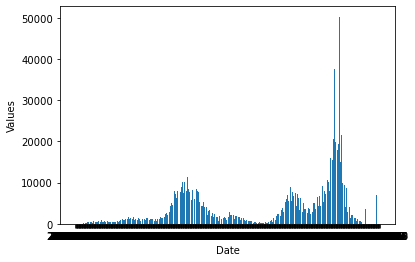

In [3]:
covid_df  = pd.read_csv('ohio_uni.csv')
covid_df = covid_df.drop('PROVINCE_STATE_NAME', axis=1)

plt.bar(covid_df['Date'], covid_df['PEOPLE_POSITIVE_NEW_CASES_COUNT'])
plt.xlabel('Date')
plt.ylabel('Values')

<AxesSubplot:xlabel='PEOPLE_POSITIVE_NEW_CASES_COUNT', ylabel='Count'>

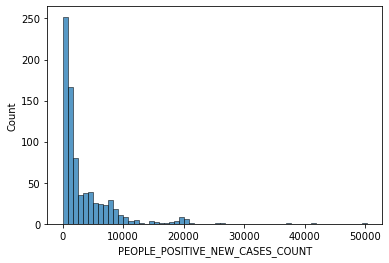

In [4]:
import seaborn as sns
sns.histplot(covid_df['PEOPLE_POSITIVE_NEW_CASES_COUNT'])

Distribution is not normal, could be an opportunity for Linear Models.

In [5]:
covid_df  = covid_df.set_index('Date')
covid_df.index = pd.to_datetime(covid_df.index)
covid_df = covid_df.sort_index()

In [6]:
from statsmodels.tsa.stattools import adfuller
adfuller(covid_df)

(-3.474005918551985,
 0.008680318487752258,
 20,
 769,
 {'1%': -3.438882201132452,
  '5%': -2.865305765357574,
  '10%': -2.568775270215655},
 14090.268170110792)

Stationarity is Good. 

In [7]:
train_size = int(len(covid_df) * 0.85)
covid_train, covid_test = covid_df[0:train_size], covid_df[train_size:]

## Cross val

In [8]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits = 5, test_size = 100, gap = 1)
covid_df = covid_df.sort_index()

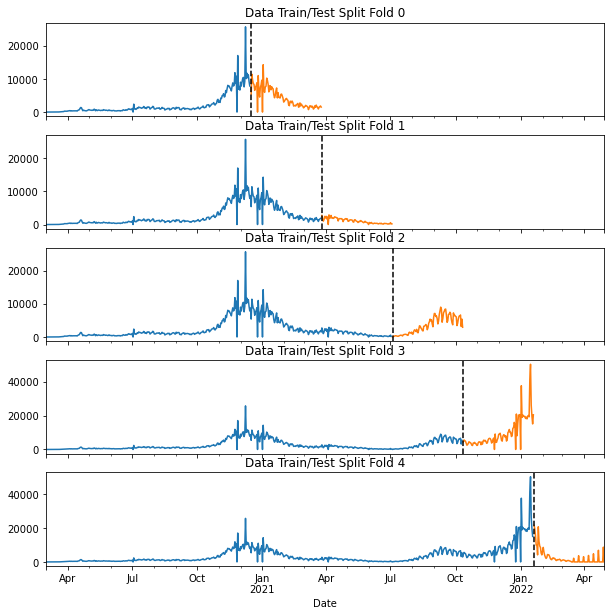

In [9]:
fig, axs = plt.subplots(5, 1, figsize=(10, 10), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(covid_df):
    train = covid_df.iloc[train_idx]
    test = covid_df.iloc[val_idx]
    train['PEOPLE_POSITIVE_NEW_CASES_COUNT'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['PEOPLE_POSITIVE_NEW_CASES_COUNT'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

## ACF & PACF

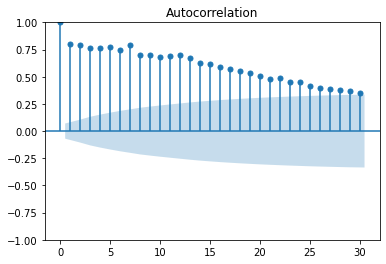

In [10]:
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
plot_acf(covid_df['PEOPLE_POSITIVE_NEW_CASES_COUNT'], lags=30);

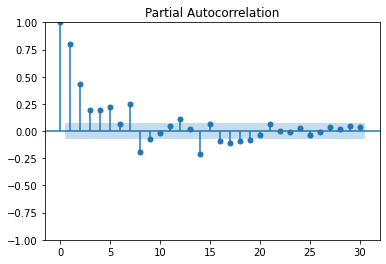

In [11]:
plot_pacf(covid_df['PEOPLE_POSITIVE_NEW_CASES_COUNT'], lags=30);

## Baseline ARIMA

In [12]:
from statsmodels.tsa.arima.model import ARIMA
base_cali_arima = ARIMA(covid_train['PEOPLE_POSITIVE_NEW_CASES_COUNT'], order=(1, 0, 1))
base_cali_arima_fit = base_cali_arima.fit()

In [13]:
base_cali_arima_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:     PEOPLE_POSITIVE_NEW_CASES_COUNT   No. Observations:                  671
Model:                              ARIMA(1, 0, 1)   Log Likelihood               -5917.044
Date:                             Tue, 05 Mar 2024   AIC                          11842.089
Time:                                     00:02:49   BIC                          11860.124
Sample:                                 03-01-2020   HQIC                         11849.074
                                      - 12-31-2021                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3004.8534   2.62e+04      0.115      0.909   -4.83e+04    5.43e+04
ar.L1          0.9986      0.006    166.851      0.000       0.987       1.010
ma.L1         -0.7591      0.015    -50.834      0.000      -0.788      -0.730
sigma2      2.657e+06   3.99e+04     66.600      0.000    2.58e+06    2.74e+06
===================================================================================
Ljung-Box (L1) (Q):                  13.51   Jarque-Bera (JB):             28431.39
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              67.90   Skew:                             1.71
Prob(H) (two-sided):                  0.00   Kurtosis:                        34.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:xlabel='Date'>

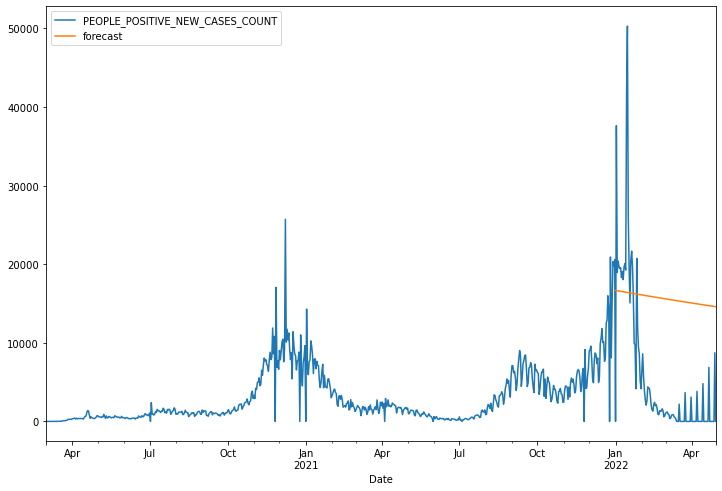

In [14]:
covid_df['forecast']= base_cali_arima_fit.forecast(steps = len(covid_test))
covid_df[['PEOPLE_POSITIVE_NEW_CASES_COUNT','forecast']].plot(figsize=(12,8))

<AxesSubplot:xlabel='Date'>

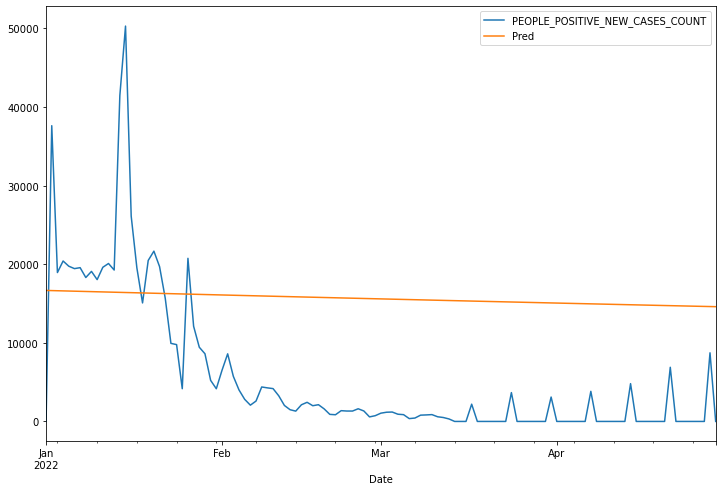

In [15]:
graph_df = pd.DataFrame(covid_test)
graph_df['Pred'] = base_cali_arima_fit.forecast(steps = len(covid_test))
graph_df[['PEOPLE_POSITIVE_NEW_CASES_COUNT','Pred']].plot(figsize=(12,8))

In [16]:
print('MAE = ', mean_absolute_error(graph_df['PEOPLE_POSITIVE_NEW_CASES_COUNT'], graph_df['Pred']))
print('MASE = ', mase(graph_df['PEOPLE_POSITIVE_NEW_CASES_COUNT'], graph_df['Pred']))
print('RMSE = ', np.sqrt(mean_squared_error(graph_df['PEOPLE_POSITIVE_NEW_CASES_COUNT'], graph_df['Pred'])))

MAE =  12251.262665508597
MASE =  5.184324886247136
RMSE =  13260.910828579305


## Tuned ARIMA

Going to try to do a Box Cox transformation to be used on linear models.

In [17]:
from scipy.stats import boxcox

covid_train_boxcox = pd.DataFrame(covid_train)
covid_train_boxcox['PEOPLE_POSITIVE_NEW_CASES_COUNT'] = covid_train_boxcox['PEOPLE_POSITIVE_NEW_CASES_COUNT'].clip(lower=1)
to_transform = covid_train_boxcox['PEOPLE_POSITIVE_NEW_CASES_COUNT'].values
transformed_data, lambda_value = boxcox(to_transform)
print("Lambda value:", lambda_value)
covid_train_boxcox['PEOPLE_POSITIVE_NEW_CASES_COUNT_new'] = transformed_data

Lambda value: 0.26873366954099326


<AxesSubplot:xlabel='PEOPLE_POSITIVE_NEW_CASES_COUNT_new', ylabel='Count'>

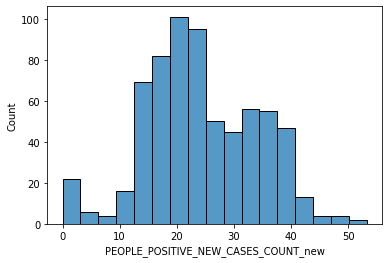

In [18]:
sns.histplot(covid_train_boxcox['PEOPLE_POSITIVE_NEW_CASES_COUNT_new'])

New distribution here is much more normal than before, hopefully helps with improving the linear models. 

<BarContainer object of 671 artists>

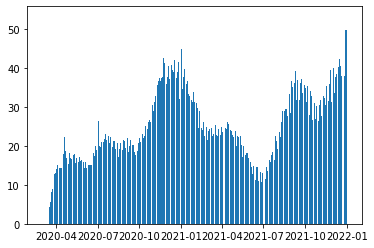

In [19]:
plt.bar(covid_train_boxcox.index, covid_train_boxcox['PEOPLE_POSITIVE_NEW_CASES_COUNT_new'])

In [20]:
# Grid Search

results=[]
for p in range(1,5):
    for q in range(1,5):
 #       cali_arima_gmodel=ARIMA(covid_train['PEOPLE_POSITIVE_NEW_CASES_COUNT'],order=(p,1,q)).fit()
        cali_arima_gmodel=ARIMA(covid_train_boxcox['PEOPLE_POSITIVE_NEW_CASES_COUNT_new'],order=(p,1,q)).fit()
        results.append([p,q,cali_arima_gmodel.aic])
pd.DataFrame(results, columns=['p','q','aic']).sort_values('aic')


,p,q,aic
15,4,4,3882.918396
13,4,2,3911.375839
11,3,4,3913.247626
14,4,3,3914.513729
10,3,3,3914.815860
9,3,2,3914.931428
3,1,4,3915.106951
7,2,4,3915.564469
1,1,2,3915.908328
6,2,3,3918.391512


In [21]:
cali_after_gmodel=ARIMA(covid_train_boxcox['PEOPLE_POSITIVE_NEW_CASES_COUNT_new'],order=(4,1,4))
cali_after_gmodel_fit =cali_after_gmodel.fit()

<AxesSubplot:xlabel='Date'>

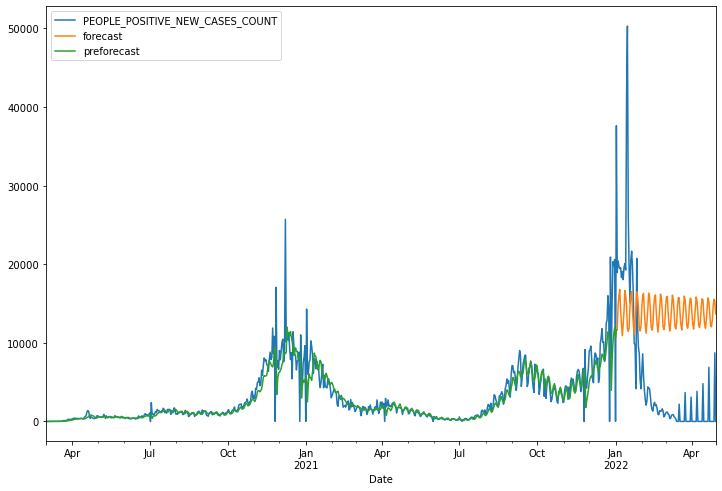

In [22]:
covid_df_predictions = pd.DataFrame(covid_df)

covid_df_predictions['forecast']= cali_after_gmodel_fit.forecast(steps = len(covid_test))
arima_back_transform_one = covid_df_predictions['forecast'].values
arima_back_transformed_one = np.power((arima_back_transform_one * lambda_value) + 1, 1 / lambda_value)
covid_df_predictions['forecast'] = arima_back_transformed_one

covid_df_predictions['preforecast']= cali_after_gmodel_fit.predict(start = 0, end = 672)
arima_back_transform_two = covid_df_predictions['preforecast'].values
arima_back_transformed_two = np.power((arima_back_transform_two * lambda_value) + 1, 1 / lambda_value)
covid_df_predictions['preforecast'] = arima_back_transformed_two

covid_df_predictions[['PEOPLE_POSITIVE_NEW_CASES_COUNT','forecast', 'preforecast']].plot(figsize=(12,8))

<AxesSubplot:xlabel='Date'>

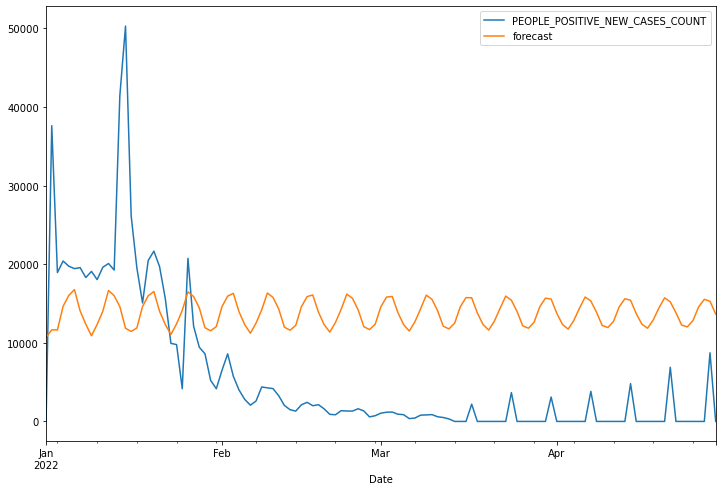

In [23]:
graph_df_1 = pd.DataFrame(covid_test)
graph_df_1['forecast']= cali_after_gmodel_fit.forecast(steps = len(covid_test))
arima_back_transform_one = graph_df_1['forecast'].values
arima_back_transformed_one = np.power((arima_back_transform_one * lambda_value) + 1, 1 / lambda_value)
graph_df_1['forecast'] = arima_back_transformed_one
graph_df_1.dropna(inplace=True)
graph_df_1[['PEOPLE_POSITIVE_NEW_CASES_COUNT','forecast']].plot(figsize=(12,8))

In [24]:
print('MAE = ', mean_absolute_error(graph_df_1['PEOPLE_POSITIVE_NEW_CASES_COUNT'], graph_df_1['forecast']))
print('MASE = ', mase(graph_df_1['PEOPLE_POSITIVE_NEW_CASES_COUNT'], graph_df_1['forecast']))
print('RMSE = ', np.sqrt(mean_squared_error(graph_df_1['PEOPLE_POSITIVE_NEW_CASES_COUNT'], graph_df_1['forecast'])))

MAE =  11305.916541555507
MASE =  4.784286002881657
RMSE =  12320.015426819651


## Baseline SARIMA

In [25]:
import statsmodels.api as sm
baseline_sarima= sm.tsa.statespace.SARIMAX(covid_train['PEOPLE_POSITIVE_NEW_CASES_COUNT'],order=(1, 1, 1),seasonal_order=(1,1,1,12))
results_sarima = baseline_sarima.fit()

<AxesSubplot:xlabel='Date'>

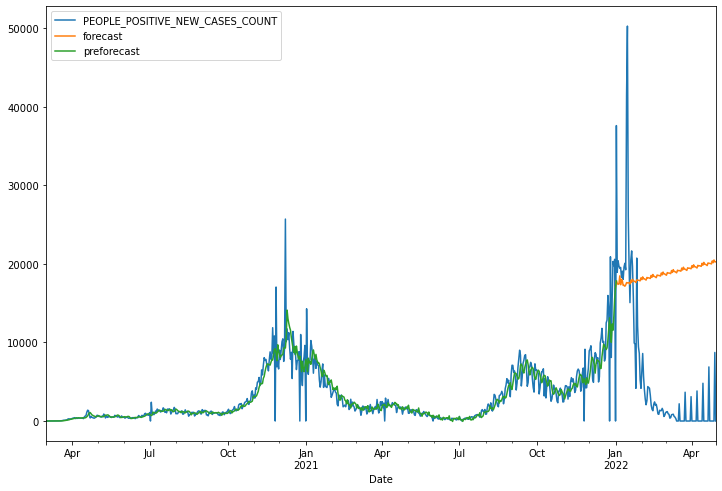

In [26]:
covid_df['forecast']= results_sarima.forecast(steps = len(covid_train))
covid_df['preforecast'] = results_sarima.predict(start = 0, end = 672)
covid_df[['PEOPLE_POSITIVE_NEW_CASES_COUNT','forecast', 'preforecast']].plot(figsize=(12,8))

<AxesSubplot:xlabel='Date'>

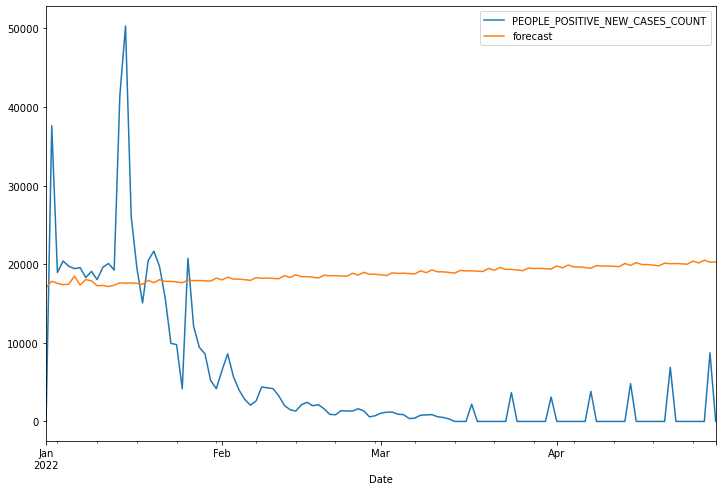

In [27]:
graph_df_3 = pd.DataFrame(covid_test)
graph_df_3['forecast']= results_sarima.forecast(steps = len(covid_test))
graph_df_3[['PEOPLE_POSITIVE_NEW_CASES_COUNT','forecast']].plot(figsize=(12,8))

In [28]:
print('MAE = ', mean_absolute_error(graph_df_3['PEOPLE_POSITIVE_NEW_CASES_COUNT'], graph_df_3['forecast']))
print('MASE = ', mase(graph_df_3['PEOPLE_POSITIVE_NEW_CASES_COUNT'], graph_df_3['forecast']))
print('RMSE = ', np.sqrt(mean_squared_error(graph_df_3['PEOPLE_POSITIVE_NEW_CASES_COUNT'], graph_df_3['forecast'])))

MAE =  15024.571140339809
MASE =  6.357896340541857
RMSE =  16347.762418322649


## Tuned SARIMA

In [29]:

if 1:
    import statsmodels.api as sm

    results=[]
    for p in range(1,3):
        for q in range(1,3):
            for P in range(1,3):
                for Q in range(1,3):
                    print(p,q,P,Q)
                    # Beaware of the data input, use your training set
                    model=sm.tsa.statespace.SARIMAX(covid_train_boxcox['PEOPLE_POSITIVE_NEW_CASES_COUNT_new'],order=(p,1,q), seasonal_order=(P,1,Q,12)).fit()
                    results.append([p,q,P,Q,model.aic])


1 1 1 1
1 1 1 2
1 1 2 1
1 1 2 2
1 2 1 1
1 2 1 2
1 2 2 1
1 2 2 2
2 1 1 1
2 1 1 2
2 1 2 1
2 1 2 2
2 2 1 1
2 2 1 2
2 2 2 1
2 2 2 2


In [30]:
df_results = pd.DataFrame(results, columns=['p', 'q', 'P', 'Q', 'aic']).sort_values('aic')
df_results

,p,q,P,Q,aic
7,1,2,2,2,3889.423260
6,1,2,2,1,3893.230684
3,1,1,2,2,3895.142368
4,1,2,1,1,3896.325865
11,2,1,2,2,3897.039354
5,1,2,1,2,3897.373211
15,2,2,2,2,3899.021511
1,1,1,1,2,3900.830112
2,1,1,2,1,3900.869404
10,2,1,2,1,3902.802001


In [40]:
sarima = sm.tsa.statespace.SARIMAX(covid_train_boxcox['PEOPLE_POSITIVE_NEW_CASES_COUNT_new'],order=(1, 1, 2),seasonal_order=(2,1,2,12))
results = sarima.fit()

<AxesSubplot:xlabel='Date'>

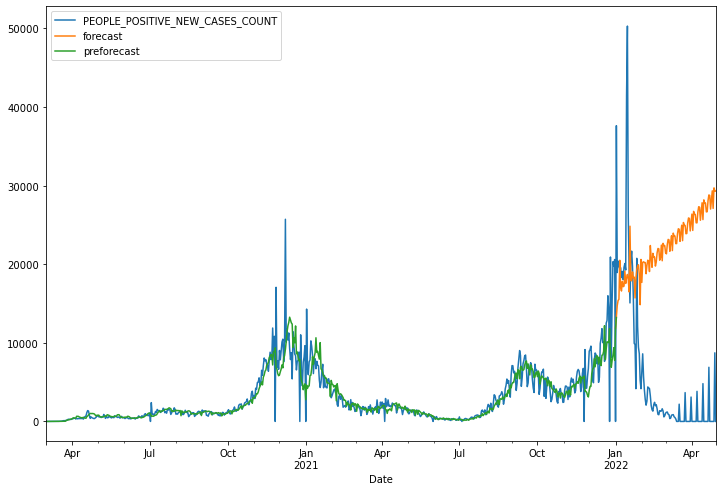

In [41]:
covid_df_sarima_predictions = pd.DataFrame(covid_df)

covid_df_sarima_predictions['forecast']=results.forecast(steps = len(covid_test))
sarima_back_transform_one = covid_df_sarima_predictions['forecast'].values
sarima_back_transformed_one = np.power((sarima_back_transform_one * lambda_value) + 1, 1 / lambda_value)
covid_df_sarima_predictions['forecast'] = sarima_back_transformed_one

covid_df_sarima_predictions['preforecast'] = results.predict(start = 0, end = 672)
sarima_back_transform_two = covid_df_sarima_predictions['preforecast'].values
sarima_back_transformed_two = np.power((sarima_back_transform_two * lambda_value) + 1, 1 / lambda_value)
covid_df_sarima_predictions['preforecast'] = sarima_back_transformed_two

covid_df_sarima_predictions[['PEOPLE_POSITIVE_NEW_CASES_COUNT','forecast', 'preforecast']].plot(figsize=(12,8))

<AxesSubplot:xlabel='Date'>

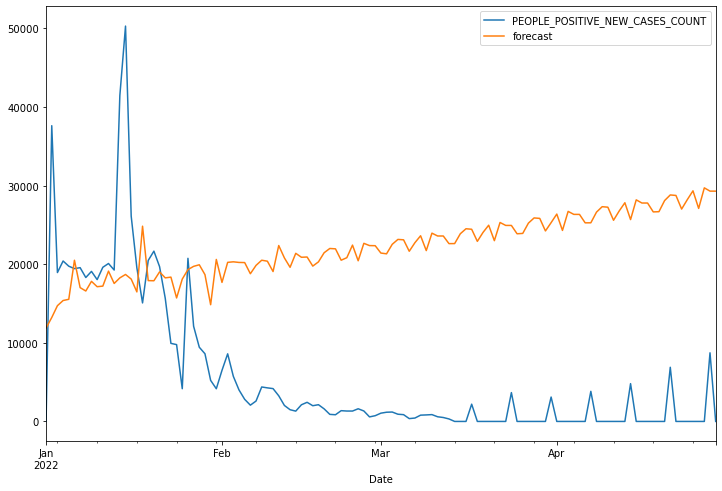

In [42]:
graph_df_4 = pd.DataFrame(covid_test)
graph_df_4['forecast']= results.forecast(steps = len(covid_test))
arima_back_transform_one = graph_df_4['forecast'].values
arima_back_transformed_one = np.power((arima_back_transform_one * lambda_value) + 1, 1 / lambda_value)
graph_df_4['forecast'] = arima_back_transformed_one
graph_df_4[['PEOPLE_POSITIVE_NEW_CASES_COUNT','forecast']].plot(figsize=(12,8))

In [43]:
print('MAE = ', mean_absolute_error(graph_df_4['PEOPLE_POSITIVE_NEW_CASES_COUNT'], graph_df_4['forecast']))
print('MASE = ', mase(graph_df_4['PEOPLE_POSITIVE_NEW_CASES_COUNT'], graph_df_4['forecast']))
print('RMSE = ', np.sqrt(mean_squared_error(graph_df_4['PEOPLE_POSITIVE_NEW_CASES_COUNT'], graph_df_4['forecast'])))

MAE =  18660.711035354096
MASE =  7.896589213454487
RMSE =  20475.67014369352


## Auto-ARIMA

In [44]:
from pmdarima import auto_arima

In [45]:
auto_model = auto_arima(covid_train_boxcox['PEOPLE_POSITIVE_NEW_CASES_COUNT_new'], seasonal=True, trace=True, suppress_warnings=True, stepwise=True, n_jobs=-1)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3925.352, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4333.558, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4080.144, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3931.010, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4331.657, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3915.454, Time=0.28 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3921.304, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3921.376, Time=0.05 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=3925.142, Time=0.24 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=3923.281, Time=0.13 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3923.371, Time=0.10 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.60 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3915.908, Time=0.18 sec

Best model:  ARIMA(1,1,2)(0,0,0)[0] intercept
Total fit time: 1.921 seconds


3915.4540020361565


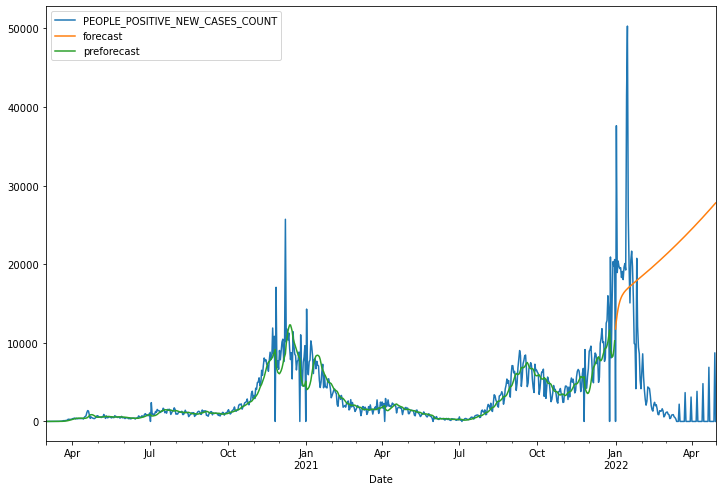

In [46]:
covid_auto_predictions = pd.DataFrame(covid_df)

auto_predictions = auto_model.predict(n_periods=len(covid_test))
auto_predictions = np.power((auto_predictions * lambda_value) + 1, 1 / lambda_value)
covid_auto_predictions['forecast'] = auto_predictions

auto_predict_before = auto_model.fittedvalues()
auto_predict_before = np.power((auto_predict_before * lambda_value) + 1, 1 / lambda_value)
covid_auto_predictions['preforecast'] = auto_predict_before

covid_auto_predictions[['PEOPLE_POSITIVE_NEW_CASES_COUNT','forecast', 'preforecast']].plot(figsize=(12,8))
print(auto_model.aic())

<AxesSubplot:xlabel='Date'>

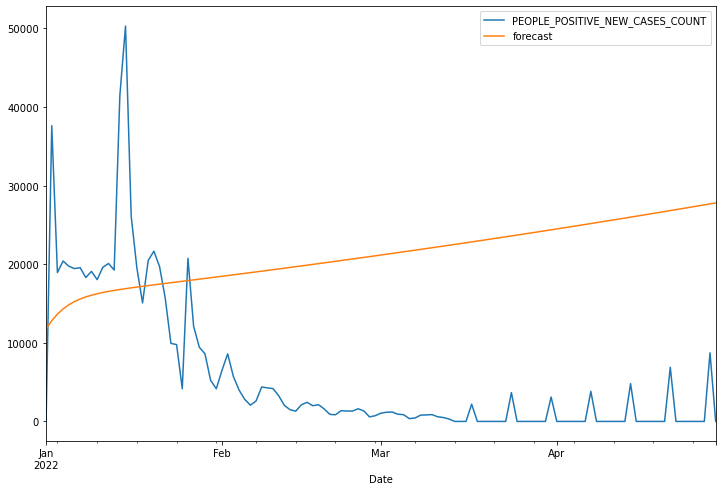

In [47]:
graph_df_5 = pd.DataFrame(covid_test)
graph_df_5['forecast']= auto_model.predict(n_periods=len(covid_test))
arima_back_transform_one = graph_df_5['forecast'].values
arima_back_transformed_one = np.power((arima_back_transform_one * lambda_value) + 1, 1 / lambda_value)
graph_df_5['forecast'] = arima_back_transformed_one
graph_df_5.dropna(inplace=True)
graph_df_5[['PEOPLE_POSITIVE_NEW_CASES_COUNT','forecast']].plot(figsize=(12,8))

In [48]:
print('MAE = ', mean_absolute_error(graph_df_5['PEOPLE_POSITIVE_NEW_CASES_COUNT'], graph_df_5['forecast']))
print('MASE = ', mase(graph_df_5['PEOPLE_POSITIVE_NEW_CASES_COUNT'], graph_df_5['forecast']))
print('RMSE = ', np.sqrt(mean_squared_error(graph_df_5['PEOPLE_POSITIVE_NEW_CASES_COUNT'], graph_df_5['forecast'])))

MAE =  18013.93358179541
MASE =  7.622894612343045
RMSE =  19660.10146421007
